In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan


label - index for the slice, not unique, just the id number for the detection in that particular slice

bbox-0-3 - the bounding box corners

bbox_area - number of pixels inside the bounding box

convex_area - Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.

eccentricity - Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.
filled_area - Number of pixels of the region will all the holes filled in. Describes the area of the filled_image.

major_axis_length - The length of the major axis of the ellipse that has the same normalized second central moments as the region.

minor_axis_length - The length of the minor axis of the ellipse that has the same normalized second central moments as the region.

# load data

In [2]:
df = pd.read_csv('data_for_chastity.csv')
# df.columns = ['sigD2','x','y','z','Div','Cur','Unknown']
df = df[['bbox_area','convex_area','eccentricity','filled_area','major_axis_length','minor_axis_length']]
df.head()

,bbox_area,convex_area,eccentricity,filled_area,major_axis_length,minor_axis_length
0,42,32,0.613612,30,7.230302,5.709102
1,80,53,0.886943,48,11.658987,5.385032
2,48,30,0.912665,27,9.581906,3.916196
3,40,29,0.906024,25,8.853080,3.746862
4,36,32,0.000000,32,6.324555,6.324555


In [3]:
df[df.major_axis_length==0].head()

,bbox_area,convex_area,eccentricity,filled_area,major_axis_length,minor_axis_length
669,1,1,0.0,1,0.0,0.0
766,1,1,0.0,1,0.0,0.0
787,1,1,0.0,1,0.0,0.0
869,1,1,0.0,1,0.0,0.0
1070,1,1,0.0,1,0.0,0.0


There are events that do not have enough information

bbox_area


Text(0, 0.5, '# events')

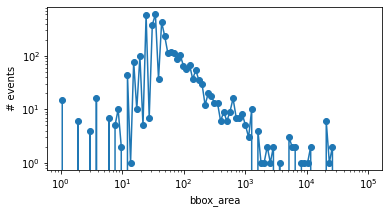

In [4]:
for col in df.columns:
    fig, ax, = plt.subplots(1,figsize=(6,3))
    y, x = np.histogram(df[col],bins=np.logspace(0,5,base=10,endpoint=True,num=100)) #[np.log10(i) for i in df[col]]
    x = [np.mean([x1,x2]) for x1, x2 in zip(x[:-1],x[1:])]
    ax.plot(x,y,'-o')
    print(col)
    break
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(col)
ax.set_ylabel('# events')

events with 50 pixels or more seem to have enough information. a sort of magnitude of completeness.

In [5]:
df2 = df.copy()[df.bbox_area>=50] # keep only those events with 50 or more pixels

In [6]:
# plot distributions of features

bbox_area
convex_area
eccentricity
filled_area
major_axis_length
minor_axis_length


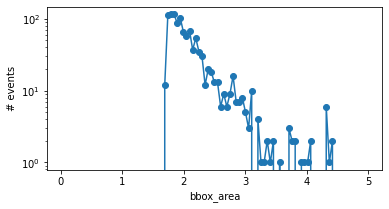

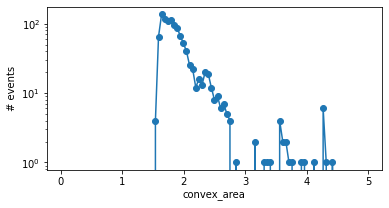

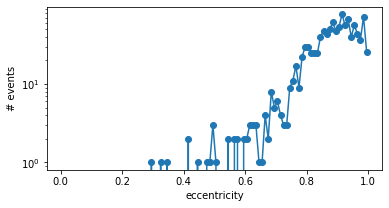

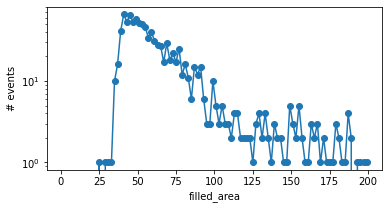

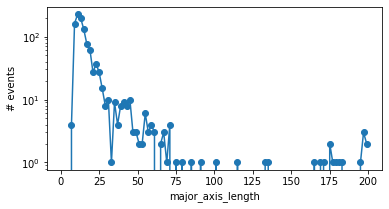

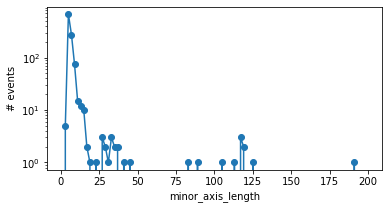

In [7]:
for col in df.columns:
    fig, ax, = plt.subplots(1,figsize=(6,3))
    if col in ['bbox_area','convex_area']:
        X = [np.log10(i) for i in df2[col]]
        xbins = np.linspace(0,5,100)
    elif col in ['eccentricity']:
        X = df2[col]
        xbins = np.arange(0,1.001,0.01)
    else:
        X = df2[col]
        xbins = np.arange(0,201,2)
        
    y, x = np.histogram(X,bins=xbins) #[np.log10(i) for i in df[col]]
    x = [np.mean([x1,x2]) for x1, x2 in zip(x[:-1],x[1:])]
    ax.plot(x,y,'-o')
    print(col)
    ax.set_yscale('log')
    ax.set_xlabel(col)
    ax.set_ylabel('# events')
    
    


bbox_area and convex_area need to be log10-ed to create noticeable differences.

In [8]:
df3 = df2.copy()
df3['log10_bbox_area'] = pd.Series([np.log10(i) for i in df3.bbox_area],index=df3.index)
df3['log10_convex_area'] = pd.Series([np.log10(i) for i in df3.convex_area],index=df3.index)
df3 = df3.drop(columns=['bbox_area','convex_area'])

In [9]:
df3.head()

,eccentricity,filled_area,major_axis_length,minor_axis_length,log10_bbox_area,log10_convex_area
1,0.886943,48,11.658987,5.385032,1.903090,1.724276
5,0.852356,40,9.870822,5.162061,1.732394,1.612784
9,0.932457,64,15.545882,5.616432,2.068186,1.863323
15,0.867774,41,10.265556,5.101555,1.698970,1.612784
19,0.879342,52,11.891102,5.662441,1.819544,1.748188


# cluster with HDBSCAN

In [10]:
m = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=2)#,cluster_selection_epsilon=0.001)
m.fit(df3)
print(len(df3))

1090


<AxesSubplot:ylabel='$\\lambda$ value'>

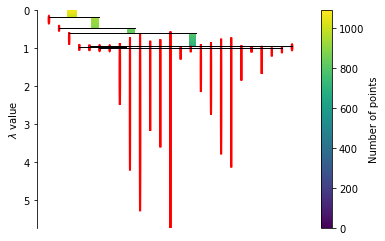

In [11]:
m.condensed_tree_.plot(select_clusters=True)

In [12]:
clusters = m.labels_
X = df3.copy()
X['clusterNumber'] = pd.Series(clusters,index=X.index)
print('# clusters: %.0f' % len(X.clusterNumber.unique()))
df_cluster = pd.concat([df3,X[['clusterNumber']]],axis=1)
df_cluster.head()

# clusters: 26


,eccentricity,filled_area,major_axis_length,minor_axis_length,log10_bbox_area,log10_convex_area,clusterNumber
1,0.886943,48,11.658987,5.385032,1.903090,1.724276,22
5,0.852356,40,9.870822,5.162061,1.732394,1.612784,11
9,0.932457,64,15.545882,5.616432,2.068186,1.863323,6
15,0.867774,41,10.265556,5.101555,1.698970,1.612784,13
19,0.879342,52,11.891102,5.662441,1.819544,1.748188,18


<AxesSubplot:xlabel='major_axis_length', ylabel='minor_axis_length'>

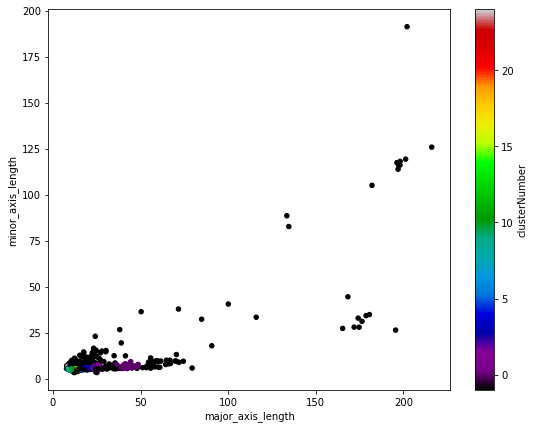

In [15]:
fig, ax = plt.subplots(figsize=(9, 7))
df_cluster.plot.scatter(x='major_axis_length', y='minor_axis_length', c='clusterNumber', cmap='nipy_spectral', ax=ax)

(0.0, 25.0)

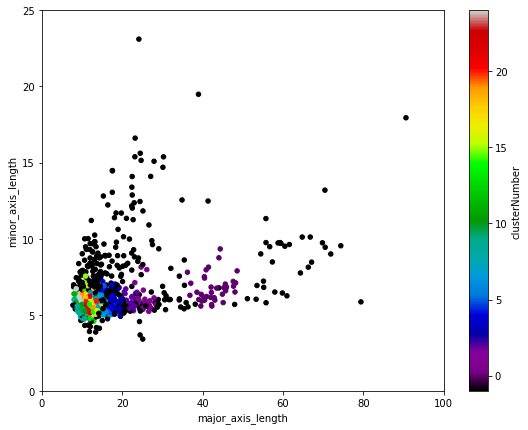

In [16]:
fig, ax = plt.subplots(figsize=(9, 7))
df_cluster.plot.scatter(x='major_axis_length', y='minor_axis_length', c='clusterNumber', cmap='nipy_spectral', ax=ax)

ax.set_xlim(0, 100)
ax.set_ylim(0, 25)

In [13]:
for c in sorted(df_cluster.clusterNumber.unique()):
    dfSlice = df_cluster.copy()[df_cluster.clusterNumber==c]
    print('cluster #',c,'; # events',len(dfSlice))

cluster # -1 ; # events 362
cluster # 0 ; # events 38
cluster # 1 ; # events 21
cluster # 2 ; # events 29
cluster # 3 ; # events 43
cluster # 4 ; # events 23
cluster # 5 ; # events 21
cluster # 6 ; # events 54
cluster # 7 ; # events 42
cluster # 8 ; # events 35
cluster # 9 ; # events 23
cluster # 10 ; # events 33
cluster # 11 ; # events 26
cluster # 12 ; # events 24
cluster # 13 ; # events 39
cluster # 14 ; # events 22
cluster # 15 ; # events 20
cluster # 16 ; # events 37
cluster # 17 ; # events 22
cluster # 18 ; # events 21
cluster # 19 ; # events 20
cluster # 20 ; # events 26
cluster # 21 ; # events 25
cluster # 22 ; # events 29
cluster # 23 ; # events 26
cluster # 24 ; # events 29


In [14]:
df_cluster.head()

,eccentricity,filled_area,major_axis_length,minor_axis_length,log10_bbox_area,log10_convex_area,clusterNumber
1,0.886943,48,11.658987,5.385032,1.903090,1.724276,22
5,0.852356,40,9.870822,5.162061,1.732394,1.612784,11
9,0.932457,64,15.545882,5.616432,2.068186,1.863323,6
15,0.867774,41,10.265556,5.101555,1.698970,1.612784,13
19,0.879342,52,11.891102,5.662441,1.819544,1.748188,18


In [15]:
df4 = pd.concat([df2,df_cluster],axis=1).T.drop_duplicates().T
df4.head()

,bbox_area,convex_area,eccentricity,filled_area,major_axis_length,minor_axis_length,log10_bbox_area,log10_convex_area,clusterNumber
1,80.0,53.0,0.886943,48.0,11.658987,5.385032,1.903090,1.724276,22.0
5,54.0,41.0,0.852356,40.0,9.870822,5.162061,1.732394,1.612784,11.0
9,117.0,73.0,0.932457,64.0,15.545882,5.616432,2.068186,1.863323,6.0
15,50.0,41.0,0.867774,41.0,10.265556,5.101555,1.698970,1.612784,13.0
19,66.0,56.0,0.879342,52.0,11.891102,5.662441,1.819544,1.748188,18.0


In [16]:
df4.to_csv('data_for_chastity_clustered.csv',index=False,index_label=None)